In [24]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import string
import pickle

warnings.filterwarnings("ignore")
import sys, os


sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

def truncate(n, dicimals=2):
    return round(n, dicimals)

# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return ">"
    elif A < B:
        return "<"
    else:
        return "="

In [2]:
# For generating Variable C
def generate_gauss_mix(
    N=5000,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class0_0=0,
    mu_class0_1=5,
    mu_class1=1,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class0_0=1,
    sig_class0_1=1,
    sig_class1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class0=None,
    split_class1=None,
):
    class0_mix = True if split_class0 is not None else False
    class1_mix = True if split_class1 is not None else False
    
    prior_0, prior_1 = prior
    p_class0, p_class1 = prior
    n0 = int(N * prior_0)  # number of samples from class 0
    n1 = N - n0  # total number of samples from class 1

    if class1_mix:
        p_class0, p_class1_0, p_class1_1 = (
            prior_0,
            prior_1 * split_class1[0],
            prior_1 * split_class1[1],
        )
        n0 = int(N * p_class0)  # number of samples from class 0
        n1 = N - n0  # total number of samples from class 1
        n1_0 = int(N * p_class1_0)  # number of samples from class 1_0
        n1_1 = n1 - n1_0  # number of samples from class 1_1
        mu_class1_0 = np.array([mu_class1_0] * p)
        mu_class1_1 = np.array([mu_class1_1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1_0 = np.identity(p) * sig_class1_0
        sig_class1_1 = np.identity(p) * sig_class1_1
        x_1_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
        x_1_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
        x_1 = np.vstack((x_1_0, x_1_1))
    else:
        # p_class0, p_class1 = prior
        mu_class1 = np.array([mu_class1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1 = np.identity(p) * sig_class1
        x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

    if class0_mix:
        p_class0_0, p_class0_1 = split_class0
        n0 = int(N * p_class0)
        n0_0 = int(n0 * p_class0_0)
        n0_1 = n0 - n0_0
        mu_class0_0 = np.array([mu_class0_0] * p)
        mu_class0_1 = np.array([mu_class0_1] * p)
        sig_class0_0 = np.identity(p) * sig_class0_0
        sig_class0_1 = np.identity(p) * sig_class0_1
        x_0_0 = np.random.multivariate_normal(mu_class0_0, sig_class0_0, size=n0_0)
        x_0_1 = np.random.multivariate_normal(mu_class0_1, sig_class0_1, size=n0_1)
        x_0 = np.vstack((x_0_0, x_0_1))
    else:
        mu_class0 = np.array([mu_class0] * p)
        x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)

    x = np.vstack((x_0, x_1))
    y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

    # Create the probability density functions (PDFs) for the two Gaussian distributions
    if class0_mix:
        pdf_class0_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class0_1 = multivariate_normal(mu_class1_1, sig_class1_1)
        p_x_given_class0_0 = pdf_class0_0.pdf(x)
        p_x_given_class0_1 = pdf_class0_1.pdf(x)
        p_x_given_class0 = (
            split_class1[0] * p_x_given_class0_0 + split_class0[1] * p_x_given_class0_1
        )
    else:
        pdf_class0 = multivariate_normal(mu_class0, sig_class0)
        p_x_given_class0 = pdf_class0.pdf(x)

    if class1_mix:
        pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
        p_x_given_class1_0 = pdf_class1_0.pdf(x)
        p_x_given_class1_1 = pdf_class1_1.pdf(x)
        p_x_given_class1 = (
            split_class1[0] * p_x_given_class1_0 + split_class1[1] * p_x_given_class1_1
        )
    else:
        pdf_class1 = multivariate_normal(mu_class1, sig_class1)
        p_x_given_class1 = pdf_class1.pdf(x)

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1

    pos_class0 = p_x_given_class0 * p_class0 / p_x
    pos_class1 = p_x_given_class1 * (1 - p_class0) / p_x

    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))

    # if class0_mix:
    #     prior_y_0 = np.array([p_class0_0, p_class0_1])
    # else:
    #     prior_y_0 = np.array(p_class0)

    # if class1_mix:
    #     prior_y_1 = np.array([p_class1_0, p_class1_1])
    # else:
    #     prior_y_1 = np.array(p_class1)
        
    entropy_y = entropy(prior, base=np.exp(1))
    correlation = np.corrcoef(x_0.T, x_1.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:, 1])
    pauc_90 = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
    pauc_98 = roc_auc_score(y, posterior[:, 1], max_fpr=0.02)
    if MI == 0.0:
        # replace the posterior with random numbers ~ U(0,1) to calculate the ROC curve
        posterior_ = np.random.uniform(0, 1, size=(N, 2))
        fpr, tpr, thresholds = metrics.roc_curve(
            y, posterior_[:, 1], pos_label=1, drop_intermediate=False
        )
    else: 
        fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = metrics.f1_score(y, y_pred)

    statistics = {
        # 'Correlation': correlation[0,1],
        "ACC": accuracy,
        "AUC": auc,
        # "F1": f1,
        "MI": MI,
        # "pAUC_90": pauc_90,
        # "pAUC_98": pauc_98,
        "S@98": tpr_s,
        # 'Sensitivity': sensitivity,
        # 'Specificity': specificity,
        # 'TN': tn,
        # 'FP': fp,
        # 'FN': fn,
        # 'TP': tp
        # "tpr": tpr,
        # "fpr": fpr,
    }
    x_min, x_max = np.min(x), np.max(x)
    # print(x_min, x_max)
    xs = np.linspace(x_min - 1, x_max + 1, 1000)
    pdf = pd.DataFrame()
    pdf["x"] = xs
    if class0_mix:
        pdf["pdf_class0"] =  split_class0[0] * pdf_class0_0.pdf(xs) + split_class0[1] * pdf_class0_1.pdf(xs)
    else:
        pdf["pdf_class0"] = pdf_class0.pdf(xs)
    if class1_mix:
        pdf["pdf_class1"] =  split_class1[0] * pdf_class1_0.pdf(xs) + split_class1[1] * pdf_class1_1.pdf(xs)
    else:
        pdf["pdf_class1"] = pdf_class1.pdf(xs)

    return x, y, posterior[:, 1], statistics, pdf

In [3]:
N = 50000
x_A, y_A, posterior_A, statistics_A, pdf_A = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1=1,
    sig_class0=1,
    sig_class1=1,
    split_class1=None,
)

In [4]:
# Generate the data
x_B, y_B, posterior_B, statistics_B, pdf_B = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class1=(0.75, 0.25),
)

In [5]:
# Generate the data
x_C, y_C, posterior_C, statistics_C, pdf_C = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0_0=0,
    mu_class0_1=5,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0_0=1,
    sig_class0_1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class0=(0.75, 0.25),
    split_class1=(0.75, 0.25),
)

In [6]:
def make_trunk_classification(
    n_samples,
    n_dim=4096,
    n_informative=1,
    simulation: str = "trunk",
    mu_0: float = 0,
    mu_1: float = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: float = 0.5,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)
    rng1 = np.random.default_rng(seed=seed)
    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])
    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_informative)
    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")
    # speed up computations for large multivariate normal matrix with SVD approximation
    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"
    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng1.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X_mixture_2 = np.fromiter(
            (
                rng1.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X = np.vstack(
            (
                X_mixture.reshape(n_samples // 2, n_informative),
                X_mixture_2.reshape(n_samples // 2, n_informative),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng1.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    else:
        raise ValueError(f"Simulation must be: trunk, trunk_overlap, trunk_mix")
    if n_dim > n_informative:
        X = np.hstack(
            (X, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim - n_informative)))
        )
    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    if return_params:
        returns = [X, y]
        if simulation == "trunk":
            returns += [[mu_0, mu_1], [cov, cov]]
        elif simulation == "trunk-overlap":
            returns += [[np.zeros(n_informative), np.zeros(n_informative)], [cov, cov]]
        elif simulation == "trunk-mix":
            returns += [*list(zip(*norm_params)), X_mixture]
        return returns
    return X, y

In [57]:
def classifier_ROC(model_name = 'svm',samplesize = 4096, sim = 'trunk',dim = 4096,reps = 1):
    POS = np.array([], dtype=np.int64).reshape(0,3)
    for cv_i in range(5):
        if model_name =='drf':
            pos_cv = np.genfromtxt(os.path.join(data_dir_drf, f"{sim}_pos_samp{samplesize}_rep{reps}_cv{cv_i}.csv"),delimiter=",")
        else:
            pos_cv = np.genfromtxt(os.path.join(data_dir_samp, f"{sim}_{model_name}_pos_samp{samplesize}_rep{reps}_cv{cv_i}.csv"),delimiter=",")
        POS = np.vstack([POS,pos_cv])
    fpr, tpr, thresholds = roc_curve(POS[:,0], POS[:,-1], pos_label=1, drop_intermediate=False,)
    return fpr, tpr

In [58]:
data_dir_samp = '/Users/yuxin/Desktop/桌面 - SUKI’s MacBook Pro/CANCER-Paper/Simulaion_Compare/results/vs_samplesize/calibrated_classifier'
data_dir_drf = '/Users/yuxin/Desktop/桌面 - SUKI’s MacBook Pro/CANCER-Paper/Simulaion_Compare/results/vs_samplesize/calibrated_classifier/drf'

In [73]:
MODELNAME = ['might','lr','knn','svm','drf']
MODELNAME_CAP = {'lr':'LR',
                 'knn':'KNN',
                 'svm':'SVM',
                 'drf':'DRF',
                 'might':'MIGHT'}
base_fpr = np.linspace(0, 1, 1001)
REPS = 10
# fpr_s = []
# tpr_s = []
# for modelname in MODELNAME:
#     TPR = np.zeros((REPS,len(base_fpr)))
#     for rep in range(REPS):
#         fpr_ori,tpr_ori = classifier_ROC(model_name = modelname,samplesize = 256, sim = 'trunk',dim = 4096,reps = rep)
#         tpr = np.interp(base_fpr, fpr_ori, tpr_ori)
#         print(tpr_ori,tpr)
#         TPR[rep,:] = tpr
#     tpr_s = np.mean(TPR, axis=0)
#     plt.plot(base_fpr,tpr_s,label = MODELNAME_CAP[modelname])
# plt.legend()

In [61]:
DIRECTORY = "/Users/yuxin/Downloads/fig1_results/"
SAMPLE = 256

with open(DIRECTORY + "fpr_linear_" + str(SAMPLE) + ".pkl", "rb") as f:
    fpr_linear_s = pickle.load(f)

with open(DIRECTORY + "tpr_linear_" + str(SAMPLE) + ".pkl", "rb") as f:
    tpr_linear_s = pickle.load(f)

with open(DIRECTORY + "fpr_nonlinear_" + str(SAMPLE) + ".pkl", "rb") as f:
    fpr_nonlinear_s = pickle.load(f)

with open(DIRECTORY + "tpr_nonlinear_" + str(SAMPLE) + ".pkl", "rb") as f:
    tpr_nonlinear_s = pickle.load(f)

with open(DIRECTORY + "fpr_null_" + str(SAMPLE) + ".pkl", "rb") as f:
    fpr_null_s = pickle.load(f)

with open(DIRECTORY + "tpr_null_" + str(SAMPLE) + ".pkl", "rb") as f:
    tpr_null_s = pickle.load(f)

In [71]:
base_fpr = np.linspace(0, 1, 1001)
N_ITR = len(tpr_null_s)

linear_might = []
nonlinear_might = []
null_might = []
for j in range(1):
    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_linear_s[i][j], tpr_linear_s[i][j])
        tpr_s.append(tpr)
        
    tpr_s = np.mean(tpr_s, axis=0)
    linear_might.append(tpr_s)
    
    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_nonlinear_s[i][j], tpr_nonlinear_s[i][j])
        tpr_s.append(tpr)
        
    tpr_s = np.mean(tpr_s, axis=0)
    nonlinear_might.append(tpr_s)
    
    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_null_s[i][j], tpr_null_s[i][j])
        tpr_s.append(tpr)
        
    tpr_s = np.mean(tpr_s, axis=0)
    null_might.append(tpr_s)

In [78]:
null_might[0].shape

(1001,)

[0.        0.0078125 0.0078125 0.0078125 0.015625  0.0234375 0.03125
 0.03125   0.0390625 0.0390625 0.0390625 0.046875  0.0546875 0.0546875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.0859375 0.09375
 0.09375   0.1015625 0.109375  0.1171875 0.1171875 0.125     0.1328125
 0.1328125 0.1328125 0.140625  0.140625  0.1484375 0.1484375 0.15625
 0.1640625 0.171875  0.1796875 0.1796875 0.1796875 0.1796875 0.1796875
 0.1796875 0.1796875 0.1796875 0.1875    0.1953125 0.1953125 0.203125
 0.2109375 0.21875   0.2265625 0.2265625 0.2265625 0.2265625 0.234375
 0.2421875 0.2421875 0.25      0.2578125 0.2578125 0.265625  0.2734375
 0.28125   0.2890625 0.2890625 0.2890625 0.296875  0.3046875 0.3046875
 0.3125    0.3203125 0.328125  0.3359375 0.34375   0.34375   0.3515625
 0.359375  0.3671875 0.3671875 0.375     0.375     0.3828125 0.3828125
 0.390625  0.3984375 0.3984375 0.3984375 0.40625   0.4140625 0.421875
 0.4296875 0.4375    0.4375    0.4375    0.4375    0.4375    0.4453125
 0.4453125 0.45

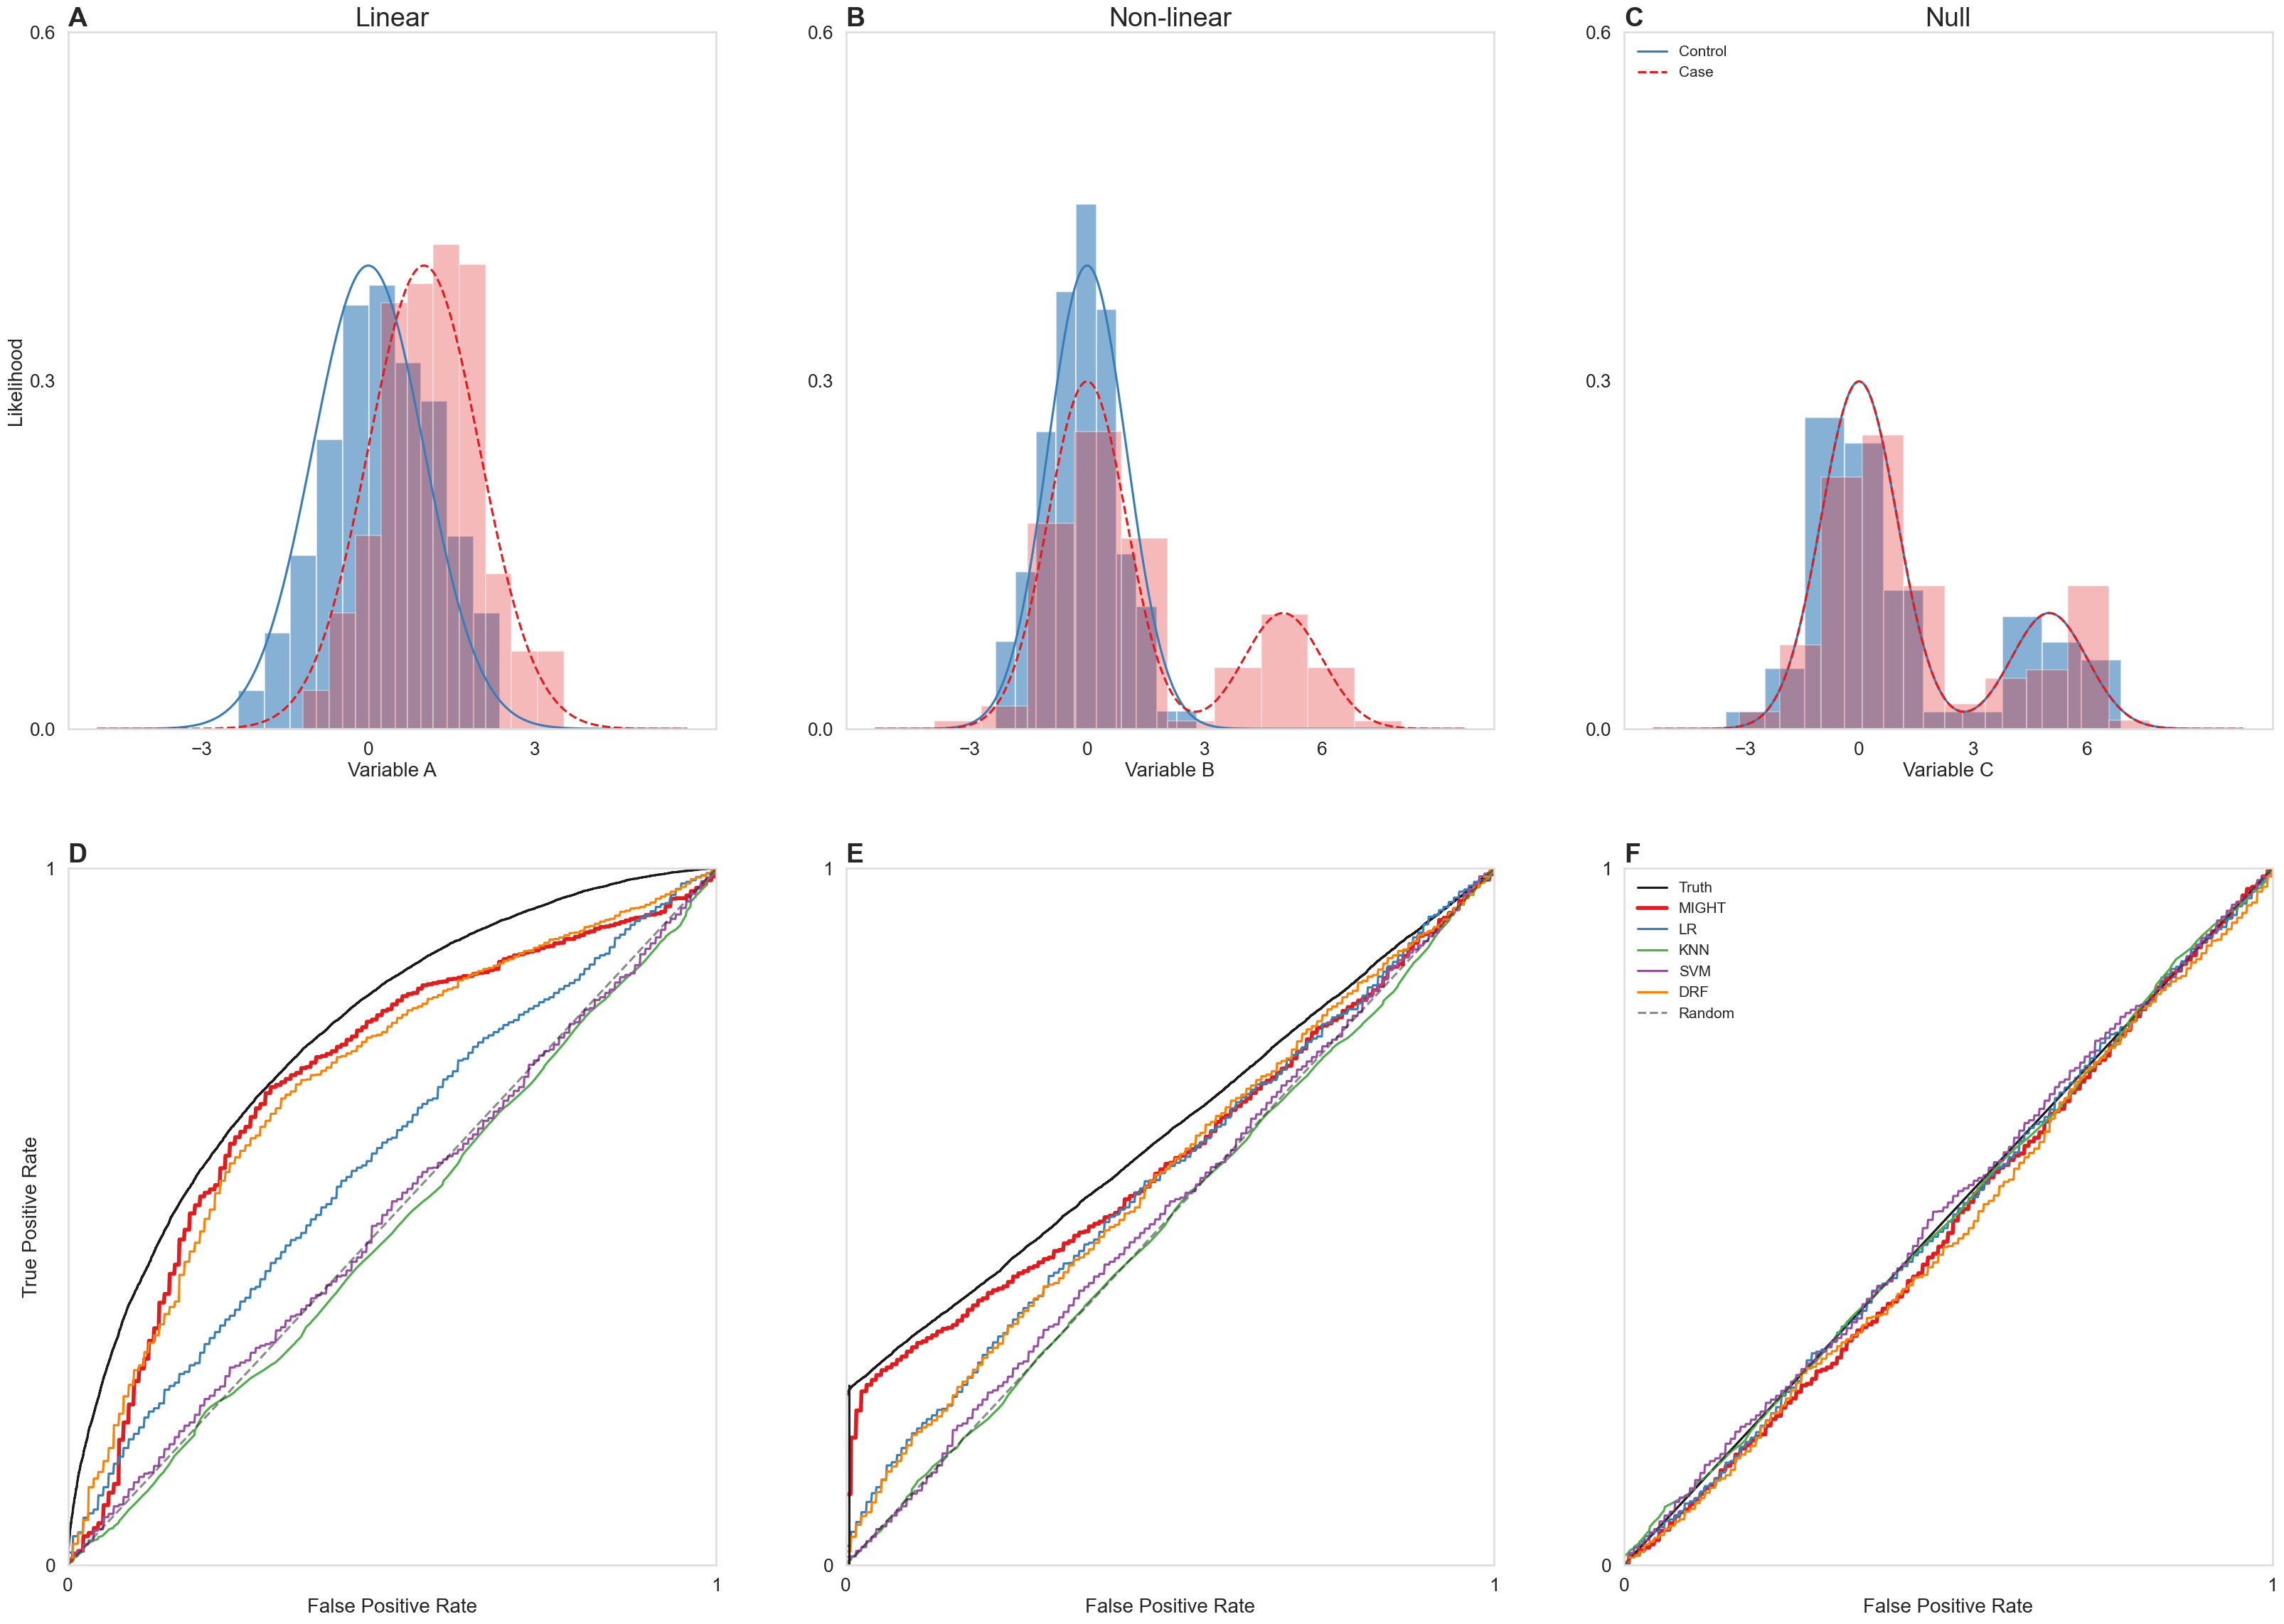

In [85]:
# plot the data
import matplotlib.gridspec as gridspec 

fontsize = 15
tablefontsize = 20
labelsize = 20
density = True
bins = 50
SAMPLE = 256
# fig, ax = plt.subplots(3, 3, figsize=(20, 22))
fig = plt.figure(figsize=(40, 28))
gs = gridspec.GridSpec(2 , 3, fig)
k = 0
plt.rcParams["axes.axisbelow"] = True
# downsample the data to plot the histograms to 250 points each
scale = N // SAMPLE
x_A_ = x_A[::scale]
y_A_ = y_A[::scale]
x_B_ = x_B[::scale]
y_B_ = y_B[::scale]
x_C_ = x_C[::scale]
y_C_ = y_C[::scale]
# plot variable A
x_0_A, x_1_A = x_A_[y_A_ == 0], x_A_[y_A_ == 1]
x_0_B, x_1_B = x_B_[y_B_ == 0], x_B_[y_B_ == 1]
x_0_C, x_1_C = x_C_[y_C_ == 0], x_C_[y_C_ == 1]
# x_min, x_max = np.min(x_A), np.max(x_A)
# xs = np.linspace(x_min-1, x_max+1, 1000)

# set the ticks size for all the plots
k = 0
for j in range(3):
    ax = fig.add_subplot(gs[0, j]) # aspect=1.0
    ax.tick_params(labelsize=labelsize - 1)
    ax.set_title(string.ascii_uppercase[k], loc="left", weight="bold")
    k += 1
    if j ==0:
        ax.hist(x_0_A[:SAMPLE // 2], density=density, alpha=0.6, color=PALETTE[1])
        ax.hist(x_1_A[:SAMPLE // 2], density=density, alpha=0.3, color=PALETTE[0])
        sns.lineplot(
            pdf_A, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax
        )
        sns.lineplot(
            pdf_A,
            x="x",
            y="pdf_class1",
            label="Case",
            color=PALETTE[0],
                ax=ax,
                linestyle="--",
            )
        # Set the axis labels
        ax.set_title("Linear")
        ax.set_xlabel("Variable A", fontsize=labelsize)
        ax.set_ylabel("Likelihood", fontsize=labelsize)
        # remove the legend
        ax.legend().remove()
        # ax[0, 0].legend(fontsize=fontsize)
        # set the xticks to just min and max
        ax.set_xticks([-3, 0, 3])
        ax.set_yticks([0.0, 0.3, 0.6])
        ax.spines["left"].set_color("#dddddd")
        ax.spines["right"].set_color("#dddddd")
        ax.spines["top"].set_color("#dddddd")
        ax.spines["bottom"].set_color("#dddddd")
    if j ==1:
        ax.hist(x_0_B[:N // 2], density=density, alpha=0.6, color=PALETTE[1])
        ax.hist(x_1_B[:N // 2], density=density, alpha=0.3, color=PALETTE[0])
        sns.lineplot(
            pdf_B, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax
        )
        sns.lineplot(
            pdf_B,
            x="x",
            y="pdf_class1",
            label="Case",
            color=PALETTE[0],
            ax=ax,
            linestyle="--",
        )
        ax.set_title("Non-linear")
        ax.set_xlabel("Variable B", fontsize=labelsize)
        ax.set_ylabel("")
        # remove the legend
        ax.legend().remove()
        # ax[0, 1].legend(fontsize=fontsize)
        # set the xtiks to integers
        # ax[0, 1].set_xticks(np.arange(-6, 9, 2))
        ax.set_xticks([-3, 0, 3, 6])
        ax.set_yticks([0.0, 0.3, 0.6])
        ax.spines["left"].set_color("#dddddd")
        ax.spines["right"].set_color("#dddddd")
        ax.spines["top"].set_color("#dddddd")
        ax.spines["bottom"].set_color("#dddddd")
        
    if j ==2:
        ax.hist(x_0_C[:N // 2], density=density, alpha=0.6, color=PALETTE[1])
        ax.hist(x_1_C[:N // 2], density=density, alpha=0.3, color=PALETTE[0])
        sns.lineplot(
            pdf_C, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax
        )
        sns.lineplot(
            pdf_C,
            x="x",
            y="pdf_class1",
            label="Case",
            color=PALETTE[0],
            ax=ax,
            linestyle="--",
        )
    
        ax.set_title("Null")
        ax.set_xlabel("Variable C", fontsize=labelsize)
        ax.set_ylabel("")
        ax.legend(fontsize=fontsize, frameon=False, loc=2)
        ax.set_xticks([-3, 0, 3, 6])
        ax.set_yticks([0.0, 0.3, 0.6])
        ax.spines["left"].set_color("#dddddd")
        ax.spines["right"].set_color("#dddddd")
        ax.spines["top"].set_color("#dddddd")
        ax.spines["bottom"].set_color("#dddddd")

# plot the ROC curve
# convert the fpr, tpr, thresholds in a dataframe
fpr_A, tpr_A, thresholds_A = metrics.roc_curve(
    y_A, posterior_A, pos_label=1, drop_intermediate=False
)
fpr_B, tpr_B, thresholds_B = metrics.roc_curve(
    y_B, posterior_B, pos_label=1, drop_intermediate=False
)
fpr_C, tpr_C, thresholds_C = metrics.roc_curve(
    y_C, posterior_C, pos_label=1, drop_intermediate=False
)
df_roc_A = pd.DataFrame({"fpr": fpr_A, "tpr": tpr_A, "thresholds": thresholds_A})
df_roc_B = pd.DataFrame({"fpr": fpr_B, "tpr": tpr_B, "thresholds": thresholds_B})
df_roc_C = pd.DataFrame({"fpr": fpr_C, "tpr": tpr_C, "thresholds": thresholds_C})

# plot the ROC curve
# remove the padding from the subplots
for j in range(3):
    ax = fig.add_subplot(gs[1, j]) # aspect=1.0
    ax.tick_params(labelsize=labelsize - 1)
    ax.set_title(string.ascii_uppercase[k], loc="left", weight="bold")
    k += 1
    if j == 0:
        ax.set_xlabel("False Positive Rate", fontsize=labelsize)
        ax.set_ylabel("True Positive Rate", fontsize=labelsize)
        # ax[1, 0].set_title("ROC Curve: Variable A")
        ax.plot(df_roc_A["fpr"], df_roc_A["tpr"], color="k")
        
        
        
        for modelname in MODELNAME:
            if modelname == 'might':
                ax.plot(base_fpr,linear_might[0],label = MODELNAME_CAP['might'],color=PALETTE[0],linewidth=4)
            else:
                TPR = np.zeros((REPS,len(base_fpr)))
                for rep in range(REPS):
                    fpr_ori,tpr_ori = classifier_ROC(model_name = modelname,samplesize = 256, sim = 'trunk',dim = 4096,reps = rep)
                    tpr = np.interp(base_fpr, fpr_ori, tpr_ori)
                    print(tpr_ori,tpr)
                    TPR[rep,:] = tpr
                tpr_s = np.mean(TPR, axis=0)
                ax.plot(base_fpr,tpr_s,label = MODELNAME_CAP[modelname])
        ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)


        # sa98 = max(
        #     [
        #         tpr_A
        #         for (fpr_A, tpr_A) in zip(fpr_A, tpr_A)
        #         if fpr_A <= 0.02
        #     ]
        # )
        # ax[1, 0].axvline(
        #     x=0.02,
        #     color=PALETTE[-2],
        #     ymin=0,
        #     ymax=sa98,
        #     #     label="S@" + str(spec) + " = " + str(round(sa98, 2)),
        #     linestyle="--",
        # )
        # ax[1, 0].axhline(y=sa98, xmin=0, xmax=0.02, color=PALETTE[-2], linestyle="--")

        # set the ticks to 0, 1
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])

        ax.spines["left"].set_color("#dddddd")
        ax.spines["right"].set_color("#dddddd")
        ax.spines["top"].set_color("#dddddd")
        ax.spines["bottom"].set_color("#dddddd")

        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)
        ax.set_ylim(top=1)
        ax.set_xlim(right=1)
        ax.set_axisbelow(True)
    
    if j == 1:

        ax.set_xlabel("False Positive Rate", fontsize=labelsize)
        ax.set_ylabel("")
        # ax[1, 1].set_title("ROC Curve: Variable B")
        ax.plot(df_roc_B["fpr"], df_roc_B["tpr"], color="k")

        for modelname in MODELNAME:
            if modelname == 'might':
                ax.plot(base_fpr,nonlinear_might[0],label = MODELNAME_CAP['might'],color=PALETTE[0],linewidth=4)
            else:
                TPR = np.zeros((REPS,len(base_fpr)))
                for rep in range(REPS):
                    fpr_ori,tpr_ori = classifier_ROC(model_name = modelname,samplesize = 256, sim = 'trunk_mix',dim = 4096,reps = rep)
                    tpr = np.interp(base_fpr, fpr_ori, tpr_ori)
                    print(tpr_ori,tpr)
                    TPR[rep,:] = tpr
                tpr_s = np.mean(TPR, axis=0)
                ax.plot(base_fpr,tpr_s,label = MODELNAME_CAP[modelname])

        ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)

        # sa98 = max(
        #     [
        #         tpr_B
        #         for (fpr_B, tpr_B) in zip(fpr_B, tpr_B)
        #         if fpr_B <= 0.02
        #     ]
        # )
        # ax[1, 1].axvline(
        #     x=0.02,
        #     color=PALETTE[-2],
        #     ymin=0,
        #     ymax=sa98,
        #     #     label="S@" + str(spec) + " = " + str(round(sa98, 2)),
        #     linestyle="--",
        # )
        # ax[1, 1].axhline(y=sa98, xmin=0, xmax=0.02, color=PALETTE[-2], linestyle="--")

        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_axisbelow(True)
        ax.vlines(
            x=0.005, ymin=0, ymax=statistics_B["S@98"] - 0.005, color="k", linestyle="-"
        )

        ax.spines["left"].set_color("#dddddd")
        ax.spines["right"].set_color("#dddddd")
        ax.spines["top"].set_color("#dddddd")
        ax.spines["bottom"].set_color("#dddddd")

        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)
        ax.set_ylim(top=1)
        ax.set_xlim(right=1)
        
    if j ==2:
        ax.set_xlabel("False Positive Rate", fontsize=labelsize)
        ax.set_ylabel("")
        # ax[1, 2].set_title("ROC Curve: Variable C")
        ax.plot(df_roc_C["fpr"], df_roc_C["tpr"], label="Truth", color="k")

        for modelname in MODELNAME:
            if modelname == 'might':
                ax.plot(base_fpr,null_might[0],label = MODELNAME_CAP['might'],color=PALETTE[0],linewidth=4)
            else:
                TPR = np.zeros((REPS,len(base_fpr)))
                for rep in range(REPS):
                    fpr_ori,tpr_ori = classifier_ROC(model_name = modelname,samplesize = 256, sim = 'trunk_overlap',dim = 4096,reps = rep)
                    tpr = np.interp(base_fpr, fpr_ori, tpr_ori)
                    print(tpr_ori,tpr)
                    TPR[rep,:] = tpr
                tpr_s = np.mean(TPR, axis=0)
                ax.plot(base_fpr,tpr_s,label = MODELNAME_CAP[modelname])



        # ax[1, 2].axvline(
        #     x=0.02,
        #     color=PALETTE[-2],
        #     ymin=0,
        #     ymax=0.02,
        #     #     label="S@" + str(spec) + " = " + str(round(sa98, 2)),
        #     linestyle="--",
        # )
        # ax[1, 2].axhline(y=0.02, xmin=0, xmax=0.02, color=PALETTE[-2], linestyle="--")
                
                
        ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
        ax.legend(fontsize=fontsize, frameon=False, loc=2)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_ylim(bottom=0)

        ax.spines["left"].set_color("#dddddd")
        ax.spines["right"].set_color("#dddddd")
        ax.spines["top"].set_color("#dddddd")
        ax.spines["bottom"].set_color("#dddddd")

        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)
        ax.set_ylim(top=1)
        ax.set_xlim(right=1)
        ax.set_axisbelow(True)

# for j in range(3):
#     ax_table = plt.subplot(gs[2,j])
#     ax_table.axis("off")
#     if j ==0 :
#         the_table = ax_table.table(cellText= statistics_linear.values,colLabels = ['TRUTH','MIGHT'],rowLabels = statistics_null.index,loc='center')
    
#     if j ==1 :
#         the_table = ax_table.table(cellText= statistics_nonlinear.values,colLabels = ['TRUTH','MIGHT'],loc='center')
    
#     if j ==2 :
#         the_table = ax_table.table(cellText= statistics_null.values,colLabels = ['TRUTH','MIGHT'],loc='center')
    
#     the_table.scale(1,6)
#     the_table.auto_set_font_size(False)
#     for cell in the_table._cells:
#         the_table._cells[cell].set_fontsize(tablefontsize+10)


